# **APTOS2019 Data Exploration** 
###### _Dataset obtained from: https://www.kaggle.com/datasets/mariaherrerot/aptos2019/data?select=valid.csv_

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image
from PIL.ExifTags import TAGS
import os
import numpy as np
import cv2

from skimage import io, color
from skimage.feature import local_binary_pattern

#### 1. Exploration of CSV Files:

In [6]:
# Viewing the first 5 rows of the 'train' csv file

train_csv_file_path = os.path.join('..', 'Data', 'APTOS-2019 Dataset', 'train.csv')
test_csv_file_path = os.path.join('..', 'Data', 'APTOS-2019 Dataset', 'test.csv')
val_csv_file_path = os.path.join('..', 'Data', 'APTOS-2019 Dataset', 'val.csv')

train_df = pd.read_csv(train_csv_file_path)
test_df = pd.read_csv(test_csv_file_path)
val_df = pd.read_csv(val_csv_file_path)

train_df.head(6)

,id_code,diagnosis
0,1ae8c165fd53,2
1,1b329a127307,1
2,1b32e1d775ea,4
3,1b3647865779,0
4,1b398c0494d1,0
5,1b4625877527,2


In [7]:
# The distrobution of the training data is given below

train_df.describe()

,diagnosis
count,2930.000000
mean,1.131058
std,1.295220
min,0.000000
25%,0.000000
50%,1.000000
75%,2.000000
max,4.000000


In [8]:
# Determining if there are any null values
train_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id_code    2930 non-null   object
 1   diagnosis  2930 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 45.9+ KB


_No null values found_

In [9]:
# Displaying the count for the different diagoses in the train, test and validate datasets

for row in ['diagnosis']:
    train_counts = train_df[row].value_counts()
    test_counts = test_df[row].value_counts()
    val_counts = val_df[row].value_counts()
    
    # Combines the counts into a single DataFrame
    counts_df = pd.DataFrame({
        'Train': train_counts,
        'Test': test_counts,
        'Val': val_counts
    }).fillna(0).astype(int)  # Fill NaN with 0 and ensure the counts are integers

    print(f"Value counts for {row}:") # Displays the combined DataFrame
    print(counts_df)
    print("\n" + "="*28 + "\n")

    

Value counts for diagnosis:
           Train  Test  Val
diagnosis                  
0           1434   199  172
1            300    30   40
2            808    87  104
3            154    17   22
4            234    33   28




_Now, looking at the CSV files in a multiclass state:_

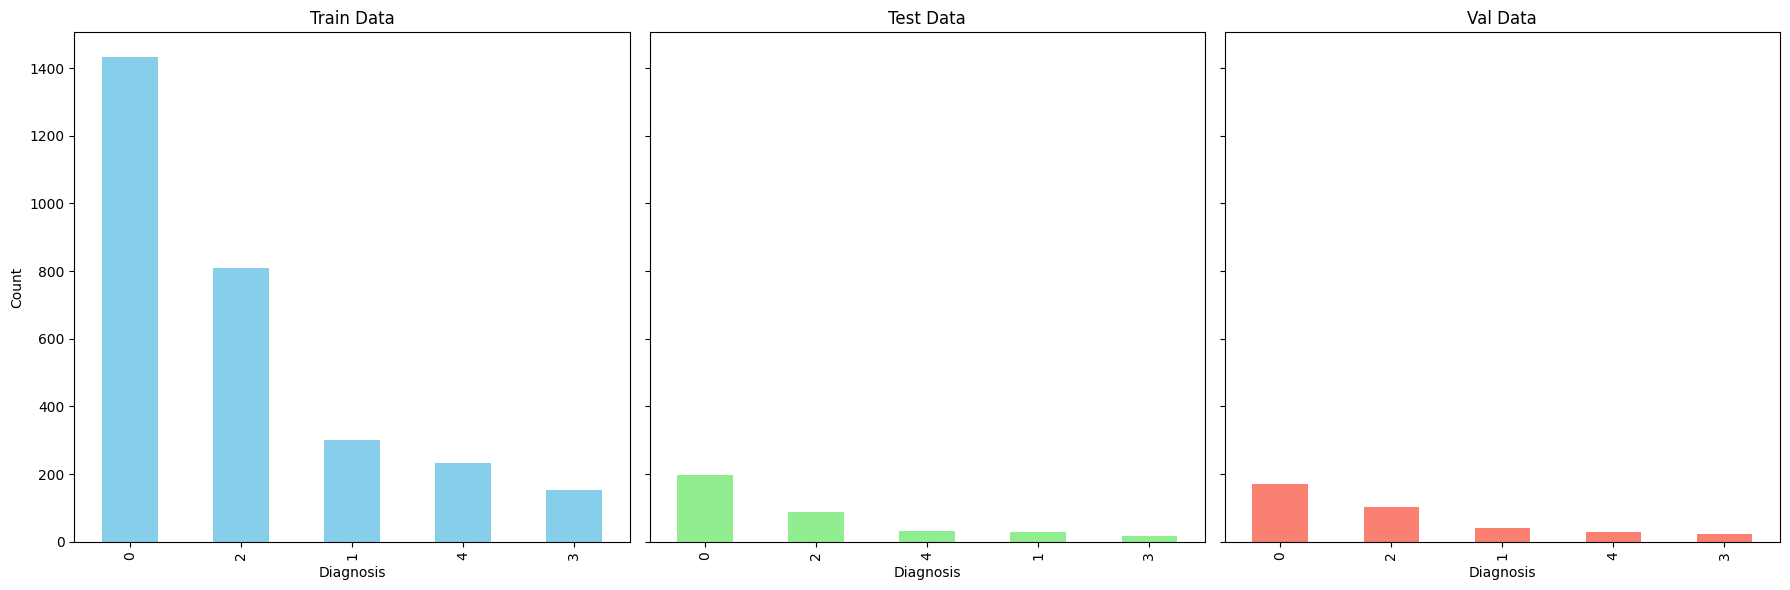

In [10]:
# Creating Histograms to View the Diagnostic Counts

fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# Plot histograms for each DataFrame
train_df['diagnosis'].value_counts().plot(kind='bar', ax=axs[0], color='skyblue')
axs[0].set_title('Train Data')
axs[0].set_xlabel('Diagnosis')
axs[0].set_ylabel('Count')

test_df['diagnosis'].value_counts().plot(kind='bar', ax=axs[1], color='lightgreen')
axs[1].set_title('Test Data')
axs[1].set_xlabel('Diagnosis')

val_df['diagnosis'].value_counts().plot(kind='bar', ax=axs[2], color='salmon')
axs[2].set_title('Val Data')
axs[2].set_xlabel('Diagnosis')

plt.tight_layout() # Adjusts layout for better spacing

plt.show()


_The counts between the different diagnosises are not equal, especially in the training set. This could become problematic in the fairness and generalisation of the model._

_Next, looking at the CSV files in a binary state:_

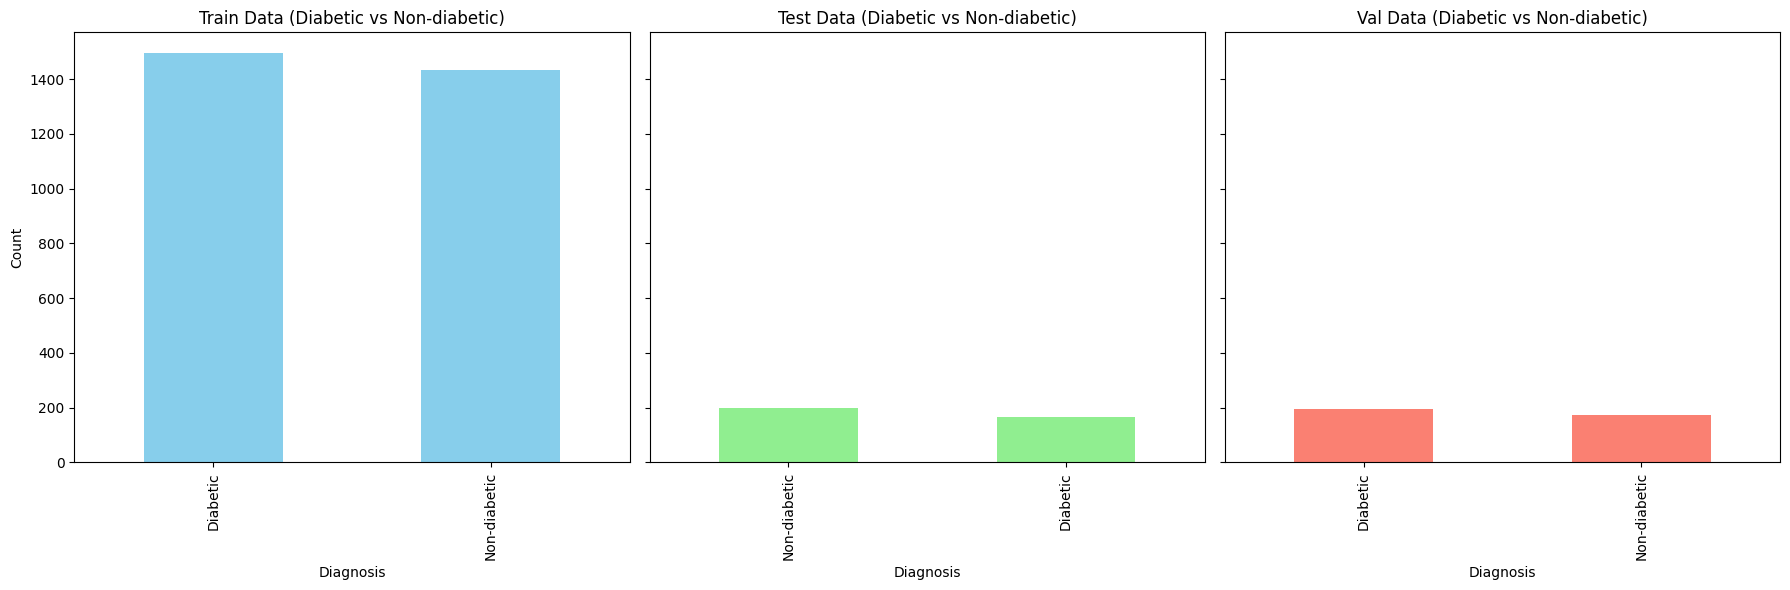

In [11]:
# Creating Histograms to View the Diagnostic Counts for the Binary Case of Diabetic vs Non-diabetic

# Combines diagnosis 1-4 into a single, diabetic category
def combine_diagnoses(df):
    df['diagnosis'] = df['diagnosis'].replace([1, 2, 3, 4], 'Diabetic')
    df['diagnosis'] = df['diagnosis'].replace([0], 'Non-diabetic')
    return df

# Applies the function to each dataset
train_df_combined = combine_diagnoses(train_df.copy())
test_df_combined = combine_diagnoses(test_df.copy())
val_df_combined = combine_diagnoses(val_df.copy())

fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# Plot histograms for each DataFrame for the binary case
train_df_combined['diagnosis'].value_counts().plot(kind='bar', ax=axs[0], color='skyblue')
axs[0].set_title('Train Data (Diabetic vs Non-diabetic)')
axs[0].set_xlabel('Diagnosis')
axs[0].set_ylabel('Count')

test_df_combined['diagnosis'].value_counts().plot(kind='bar', ax=axs[1], color='lightgreen')
axs[1].set_title('Test Data (Diabetic vs Non-diabetic)')
axs[1].set_xlabel('Diagnosis')

val_df_combined['diagnosis'].value_counts().plot(kind='bar', ax=axs[2], color='salmon')
axs[2].set_title('Val Data (Diabetic vs Non-diabetic)')
axs[2].set_xlabel('Diagnosis')

plt.tight_layout()

plt.show()

_The counts for diabetic vs non-diabetic are similar in all sections of this dataset. This means from a binary standpoint, the data is balanced. This is prefered as it will minimise bias in the model, improve the model generalisation and the model fairness._

#### 2. Exploration of Images:

In [12]:
# Looking to see if there is anything within the metadata of the images

image_path_1 = os.path.join('..', 'Data', 'APTOS-2019 Dataset', 'train_images', '1ae8c165fd53.png')

def get_image_metadata(image_path):

    image = Image.open(image_path)
    
    exif_meta_data = image._getexif() # Extracts the metadata
    
    if exif_meta_data is not None:
        # Converts the EXIF data to a more readable format
        metadata = {}
        for tag, value in exif_meta_data.items():
            tag_name = TAGS.get(tag, tag)
            metadata[tag_name] = value
        return metadata
    else:
        return "No EXIF metadata found."

metadata_1 = get_image_metadata(image_path_1) # Gets the metadata

print("Metadata for Image:") # Displays the metadata
if isinstance(metadata_1, dict):
    for key, value in metadata_1.items():
        print(f"{key}: {value}")
else:
    print(metadata_1)


Metadata for Image:
No EXIF metadata found.


In [7]:
# Displaying the Dimensions, Aspect Ratio and Resolution for the first 5 images in the Training Folder 

train_images_dir = os.path.join('..', 'Data', 'APTOS-2019 Dataset', 'train_images')

image_files = os.listdir(train_images_dir) # Gets the list of image file names in the training dataset

def get_image_dimensions_and_aspect_ratio(image_path):
    with Image.open(image_path) as img:
        width, height = img.size
        aspect_ratio = width / height
        resolution = width*height
        return width, height, aspect_ratio, resolution

image_data = [] # Stores the data for each image

# Analyses the first 5 images
for i, image_file in enumerate(image_files[:5]):
    image_path = os.path.join(train_images_dir, image_file)
    width, height, aspect_ratio, resolution = get_image_dimensions_and_aspect_ratio(image_path)
    
    # Appends the data to the list (image_data)
    image_data.append({
        'Image Name': image_file,
        'Dimensions': f"{width}x{height}",
        'Aspect Ratio': f"{aspect_ratio:.2f}",
        'Resolution': f"{resolution}"
    })

# Converts the list to a DataFrame for display
image_df = pd.DataFrame(image_data, index=[f"Image {i+1}" for i in range(len(image_data))])

image_df.head()



,Image Name,Dimensions,Aspect Ratio,Resolution
Image 1,1ae8c165fd53.png,3216x2136,1.51,6869376
Image 2,1b329a127307.png,2588x1958,1.32,5067304
Image 3,1b32e1d775ea.png,1504x1000,1.50,1504000
Image 4,1b3647865779.png,819x614,1.33,502866
Image 5,1b398c0494d1.png,1050x1050,1.00,1102500


_The image dimensions and aspect ratios are not consistent. This means that during preprocessing the images must be cropped or padded to be uniform and to fit into the models._ 

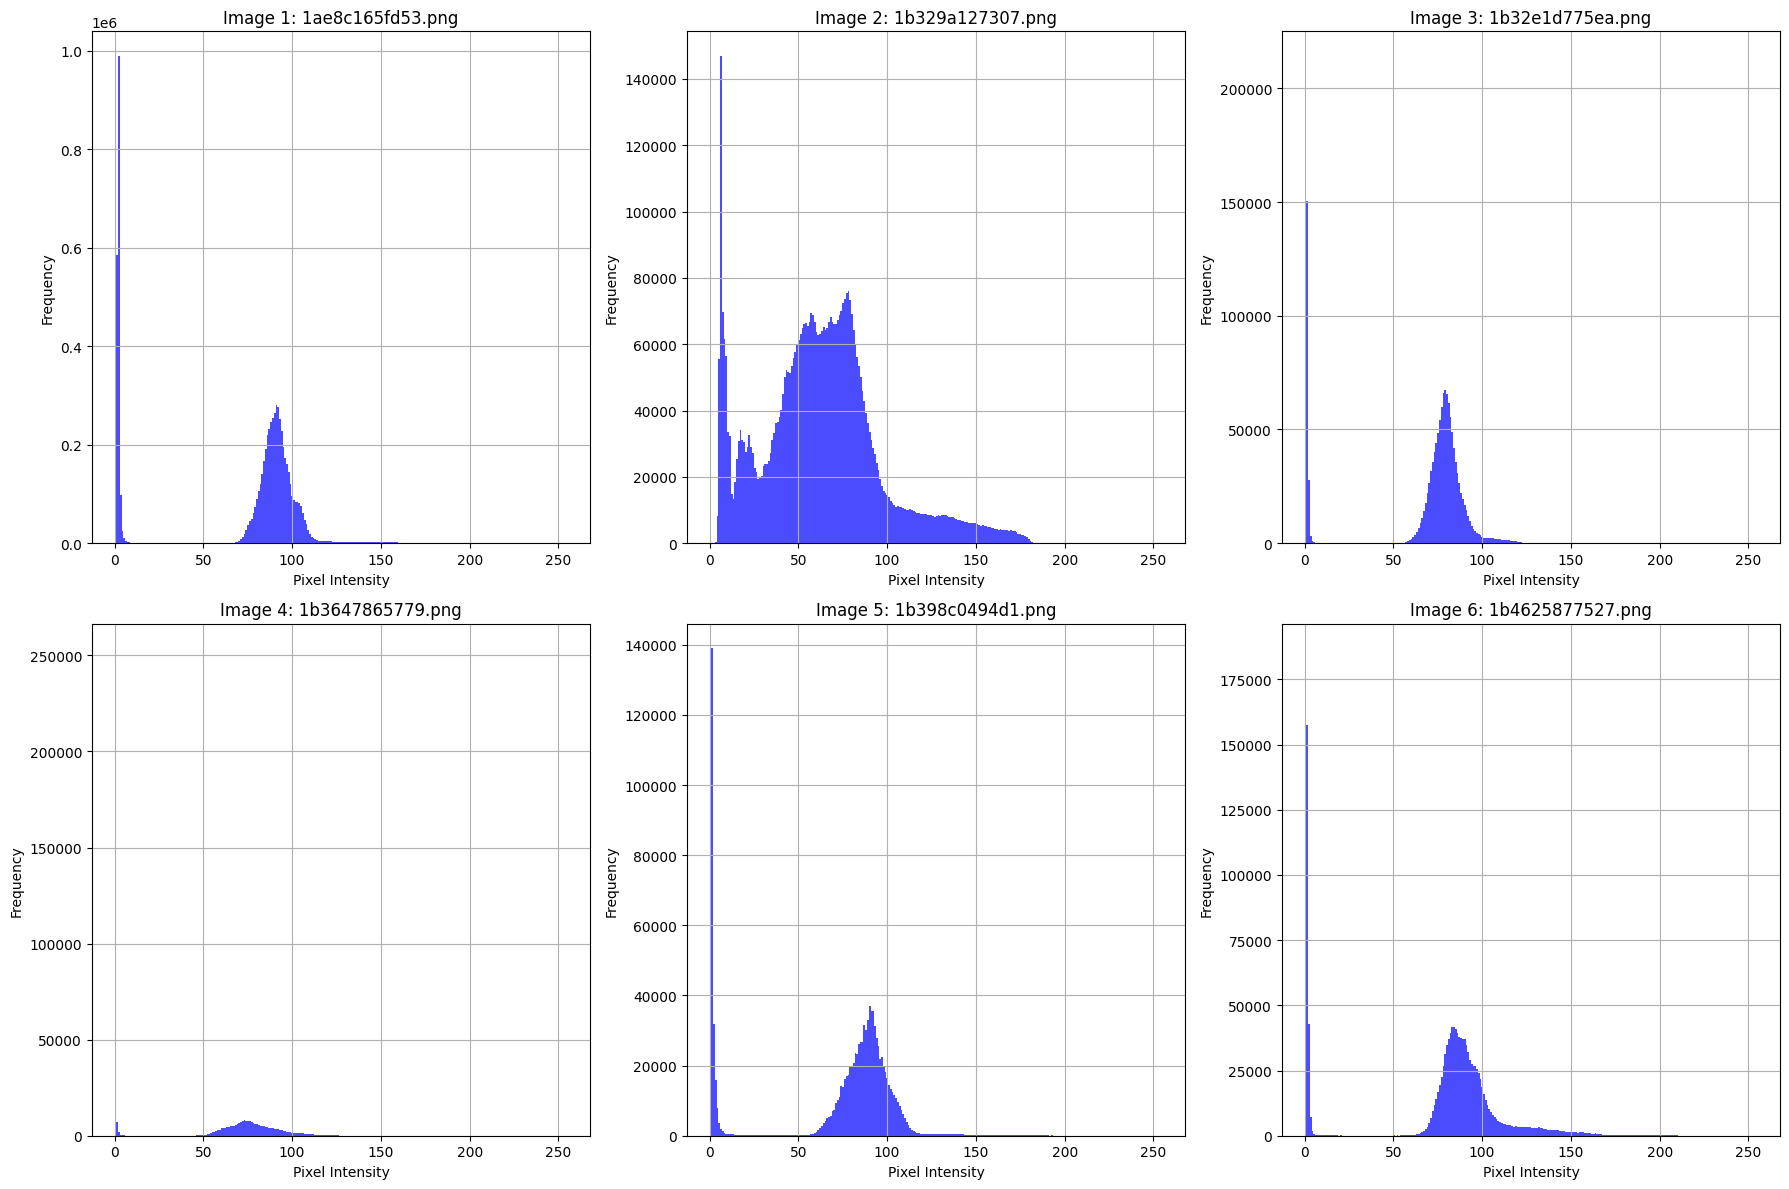

In [8]:
# Displaying the pixel intesisty distrobution for the first 6 images in the Training Folder 

fig, axs = plt.subplots(2, 3, figsize=(18, 12)) # Sets up the subplot (2 rows, 3 coloums)

# Analyses the first 6 images
for i, image_file in enumerate(image_files[:6]):
    image_path = os.path.join(train_images_dir, image_file)
    
    with Image.open(image_path) as img:
        grayscale_img = img.convert('L') # Converts the images to grayscale to allow the pixel intensities to be found (0 for black, 255 for white)
    
    pixel_values = np.array(grayscale_img).flatten() # Flattens the image into 1D to make plotting the distrobution easier
    
    # Determining the current row and column in the subplot grid
    row = i // 3
    col = i % 3
    
    # Plot the histogram of pixel intensity values in the corresponding subplot
    axs[row, col].hist(pixel_values, bins=256, range=(0, 255), color='blue', alpha=0.7)
    axs[row, col].set_title(f"Image {i+1}: {image_file}")
    axs[row, col].set_xlabel('Pixel Intensity')
    axs[row, col].set_ylabel('Frequency')
    axs[row, col].grid(True)

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()



_All images have a spike at 0, indicating there is a lot of black in the image. This is predominantly from the black background of the images. The black backround can be removed by thresholding the images such that the pixel intensity of 0 is removed._
_Images 1, 3 and 5 have many pixels clustered around a single pixel intensity indicating that there is minimal contrast in the images. This may need to be addessed in the preprocessing stages._
_Image 4 has a much lower frequency compared to the other images because it has much smaller dimentions than the other images. Hence it has fewer pixels._ 

In [15]:
# Determining the Sharpness of the First 6 Images in the Training Dataset

# Function that uses the varience of the Laplacian to calculate the sharpness of the image
def calculate_sharpness(image):
    gray_image = np.array(image.convert('L')) # Converts the image to grayscale
    
    laplacian_var = cv2.Laplacian(gray_image, cv2.CV_64F).var() # Calculates the Laplacian (second derivative)
    
    return laplacian_var

sharpness_data = [] # List to store the sharpness for each image

# Analyses the first 6 images
for i, image_file in enumerate(image_files[:6]):
    image_path = os.path.join(train_images_dir, image_file)
    
    with Image.open(image_path) as img:
        sharpness = calculate_sharpness(img) # Calculates sharpness
    
    # Appends the sharpness to the list
    sharpness_data.append({
        'Image Name': image_file,
        'Sharpness': sharpness
    })

sharpness_df = pd.DataFrame(sharpness_data, index=[f"Image {i+1}" for i in range(len(sharpness_data))]) # Converts the list to a DataFrame for display

print("\nSharpness for the first 6 images:")
sharpness_df.head(6)



Sharpness for the first 6 images:


,Image Name,Sharpness
Image 1,1ae8c165fd53.png,4.018021
Image 2,1b329a127307.png,14.160044
Image 3,1b32e1d775ea.png,30.042062
Image 4,1b3647865779.png,25.335370
Image 5,1b398c0494d1.png,38.478888
Image 6,1b4625877527.png,33.921139


_From the calculated sharpness, the first image is the most blurry while the fifth image is the sharpest. In preprocessing, maybe look at increasing the image sharpness if it is below a certain value._

In [16]:
# Displays the Signal to Noise Ratio for the First 6 Images in the Training Dataset

# Function calculates the SNR of an image
def calculate_snr(image):
    img_array = np.array(image) # Converts image to a numpy array
    
    # Calculates the mean and standard deviation of the pixel values
    mean_signal = np.mean(img_array)
    std_noise = np.std(img_array)
    
    if std_noise == 0: # Ensures no division by zero
        return float('inf')
    
    snr = mean_signal / std_noise # Calculates the SNR
    return snr

snr_data = [] # List to store the SNR for each image

# Analyses the first 6 images
for i, image_file in enumerate(image_files[:6]):
    image_path = os.path.join(train_images_dir, image_file)
    
    with Image.open(image_path) as img:
        snr = calculate_snr(img) # Calculates the SNR
    
    # Appends the SNR to the list
    snr_data.append({
        'Image Name': image_file,
        'SNR': snr
    })

snr_df = pd.DataFrame(snr_data, index=[f"Image {i+1}" for i in range(len(snr_data))]) # Converts the list to a DataFrame for display

print("Signal-to-Noise Ratio (SNR) for the first 6 images:")
snr_df.head(6)

Signal-to-Noise Ratio (SNR) for the first 6 images:


,Image Name,SNR
Image 1,1ae8c165fd53.png,0.987323
Image 2,1b329a127307.png,1.664213
Image 3,1b32e1d775ea.png,1.064641
Image 4,1b3647865779.png,0.669838
Image 5,1b398c0494d1.png,0.934805
Image 6,1b4625877527.png,1.136835


_The SNR is calculated by dividing the mean pixel value by the standard deviation of the pixel values. Not sure if this is a valid method or if this metric has much value._

In [17]:
# Maybe look at the SNR for different diagnoses (i.e., see if the averge noise for the different classes, 0-4, is wildly different - plot in histogram)

# maybe also look at image texture (either of the first 5 images or average texture for the different classes)

c:\Users\Kaylin\OneDrive\Documents\Fourth Year IE 2024\Investigation Project\ELEN4012A-Investigation-Project\InvestigationEnv\Lib\site-packages\skimage\feature\texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


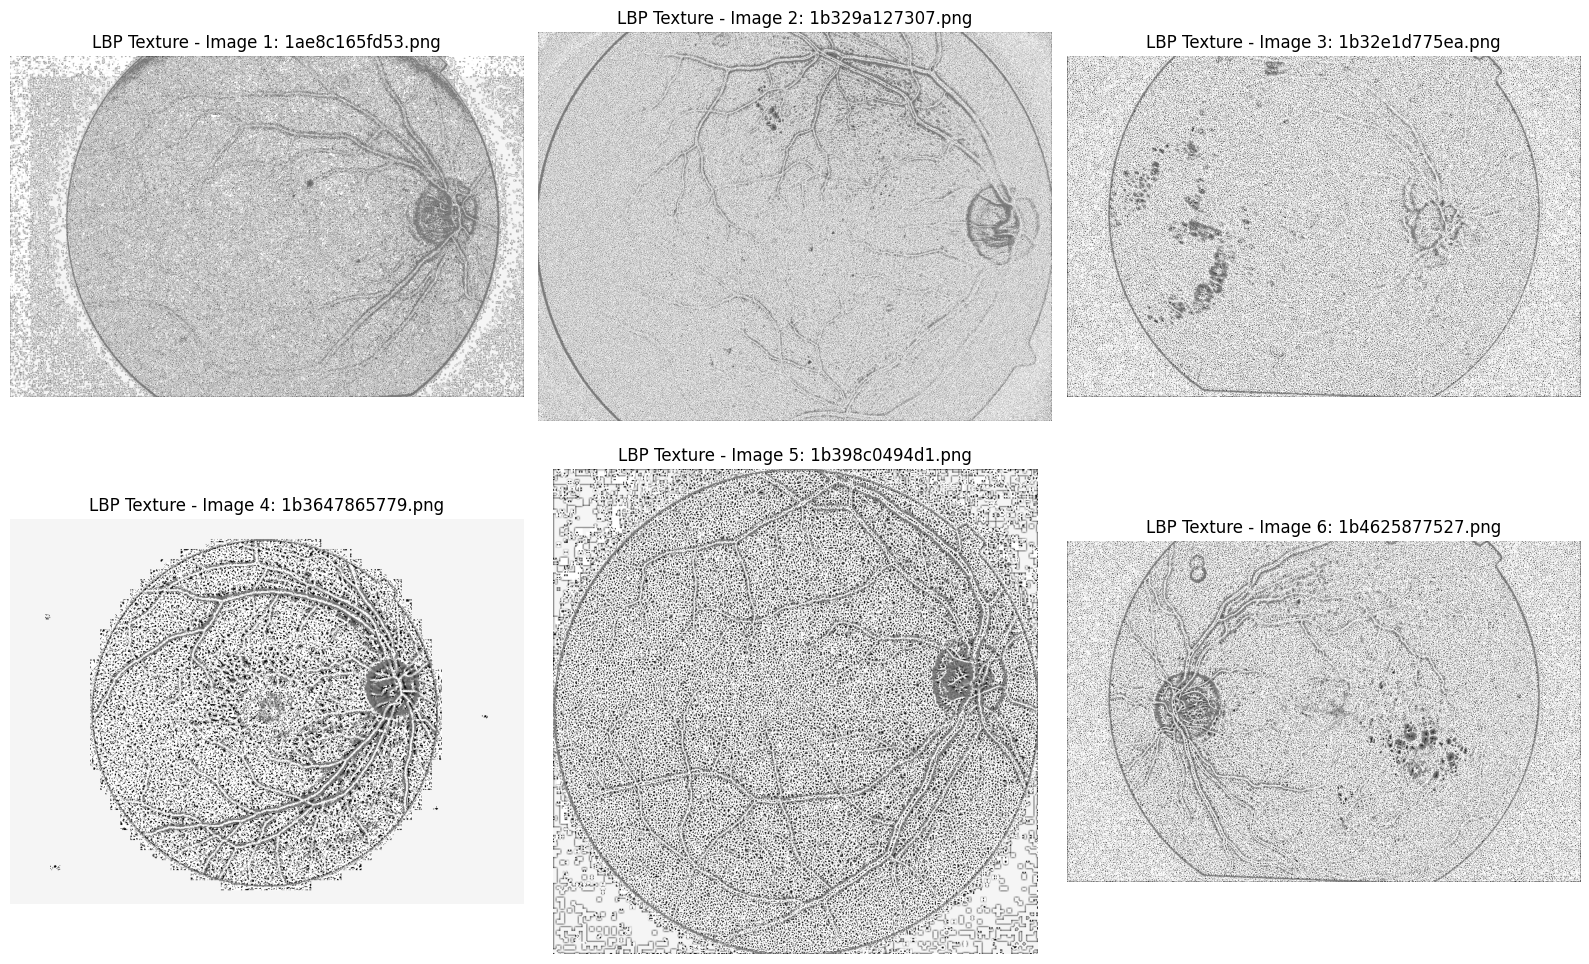

In [18]:
# Displaying the Texture of the First 6 Images in the Training Dataset

# Parameters for Local Binary Patterns (LBP)
radius = 3  # Radius of circle over which the neighborhood is considered for each pixel
n_points = 8 * radius  # Number of points to consider around each pixel

fig, axs = plt.subplots(2, 3, figsize=(16, 10)) # Set up the figure with 2 rows and 3 columns of subplots

# Analyses the first 6 images
for i, image_file in enumerate(image_files[:6]):
    image_path = os.path.join(train_images_dir, image_file)
    
    image = io.imread(image_path) # Loading the image
    
    gray_image = color.rgb2gray(image) # Converting the image to grayscale
    
    lbp = local_binary_pattern(gray_image, n_points, radius, method='uniform') # Computing the LBP
    
    # Determining the current row and column in the subplot grid
    row = i // 3
    col = i % 3
    
    # Plotting the LBP image in the corresponding subplot
    axs[row, col].imshow(lbp, cmap='gray')
    axs[row, col].set_title(f"LBP Texture - Image {i+1}: {image_file}")
    axs[row, col].axis('off')

plt.tight_layout() # Adjusts the layout for better spacing

plt.show()


_The texture of the first 6 images in the training dataset is given above. The texture is found using local binary patterns (LBP). The LBP captures the local texture by comparing each pixel to its neighbouring pixels and encoding this information into a binary pattern. Black dots/spots that differ from the general texture of the rest of the image, can be seen in Images 1,2,3 and 6. These are indicative of spots as a result of diabetes._ 

_Image 4 has the worst SNR which causes the grainy texture. Whereas Image 2 has the best SNR and it is the smoothest. (Image 5 has the second worst SNR and is also quite grainy)._